In [1]:
# Check core SDK version number
import azureml.core

print("SDK version:", azureml.core.VERSION)

SDK version: 1.37.0


In [2]:
from azureml.telemetry import set_diagnostics_collection

set_diagnostics_collection(send_diagnostics=True)

Turning diagnostics collection on. 


In [3]:
from azureml.core.workspace import Workspace

ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

Workspace name: ml-demo-workspace
Azure region: southeastasia
Subscription id: ac83d87d-3386-44f1-8390-4a56ed431b37
Resource group: demo-personal


In [4]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = 'v100-4X2nodes'
try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target.')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NC24rs_v3',
                                                           max_nodes=2)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

# use get_status() to get a detailed status for the current AmlCompute. 
print(compute_target.get_status().serialize())

Found existing compute target.
{'currentNodeCount': 0, 'targetNodeCount': 0, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2022-02-10T13:09:21.411000+00:00', 'errors': None, 'creationTime': '2022-02-10T05:45:12.740712+00:00', 'modifiedTime': '2022-02-10T05:45:16.342445+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 2, 'nodeIdleTimeBeforeScaleDown': 'PT120S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_NC24RS_V3'}


In [5]:
project_folder = './dino'
os.makedirs(project_folder, exist_ok=True)

In [8]:
from azureml.core import Experiment

experiment_name = 'exp-V100'
experiment = Experiment(ws, name=experiment_name)

In [31]:
from azureml.core import Environment

#pytorch_env = Environment.get(ws, name='AzureML-PyTorch-1.6-GPU')
#pytorch_env = Environment.from_conda_specification(name='AzureML-PyTorch-1.6-GPU',file_path='distributed-pytorch-with-distributeddataparallel.yml')
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies

#curated_env_name = 'AzureML-PyTorch-1.6-GPU'
curated_env_name = 'AzureML-pytorch-1.7-ubuntu18.04-py37-cuda11-gpu'
pytorch_env = Environment.get(workspace=ws, name=curated_env_name)
pytorch_env.environment_variables = {"AZUREML_DOWNLOAD_CONCURRENCY":384} 

dino_env = pytorch_env.clone("dino_env")

conda = CondaDependencies()

# add conda packages
conda.add_conda_package('python=3.6')
conda.add_conda_package('pytorch=1.7.1')
conda.add_conda_package('torchvision=0.8.2')

# add pip packages
conda.add_pip_package('submitit')

# add pip packages
conda.add_pip_package('timm')
# create environment
#env = Environment('curated_clone')
dino_env.python.conda_dependencies = conda



In [23]:
from azureml.core import Workspace, Dataset, Datastore
ws = Workspace.from_config()
dataset = Dataset.get_by_name(ws, name='imagenet_2015_premium')

In [12]:
#from azureml.core import Dataset

datastore = ws.get_default_datastore()
#uncomment below if running for first time
#dataset = Dataset.File.upload_directory(
#    src_dir=DATA_DIR, target=(datastore, DATA_DIR)
#)


In [24]:
from azureml.data import OutputFileDatasetConfig
output= OutputFileDatasetConfig(destination=(datastore, 'output'))


In [32]:
#training
from azureml.core import ScriptRunConfig
from azureml.core.runconfig import PyTorchConfiguration

# create distributed config
distr_config = PyTorchConfiguration(communication_backend='Nccl',process_count=8, node_count=2)
# create args
args = ["--arch", "vit_small","--data_path", dataset.as_download(),"--patch_size", 32,"--norm_last_layer",False, \
"--warmup_teacher_temp", 0.04, "--teacher_temp", 0.07, "--use_fp16", False, "--weight_decay", 0.04,\
  "--weight_decay_end", 0.4, "--clip_grad", 0, "--batch_size_per_gpu", 16, "--epochs", 7, "--freeze_last_layer", \
  1, "--lr", 0.0005, "--warmup_epochs", 2, "--min_lr", 1e-05, "--local_crops_number", 10, "--seed", 0, "--num_workers", 10,\
    "--optimizer", 'adamw', "--momentum_teacher", 0.996,\
     "--use_bn_in_head", False, "--drop_path_rate", 0.1,\
     "--global_crops_scale", 0.25 , 1.0,"--local_crops_scale",0.05, 0.25,'--saveckp_freq',4, '--output_dir', output.as_mount()]

print(args)
# #create job config
src = ScriptRunConfig(source_directory=project_folder,                    
                      script='main_dino.py',
                       arguments=args,
                       compute_target=compute_target,
                       environment=dino_env,
                       distributed_job_config=distr_config)







['--arch', 'vit_small', '--data_path', <azureml.data.dataset_consumption_config.DatasetConsumptionConfig object at 0x7fcf3bedd490>, '--patch_size', 32, '--norm_last_layer', False, '--warmup_teacher_temp', 0.04, '--teacher_temp', 0.07, '--use_fp16', False, '--weight_decay', 0.04, '--weight_decay_end', 0.4, '--clip_grad', 0, '--batch_size_per_gpu', 16, '--epochs', 7, '--freeze_last_layer', 1, '--lr', 0.0005, '--warmup_epochs', 2, '--min_lr', 1e-05, '--local_crops_number', 10, '--seed', 0, '--num_workers', 10, '--optimizer', 'adamw', '--momentum_teacher', 0.996, '--use_bn_in_head', False, '--drop_path_rate', 0.1, '--global_crops_scale', 0.25, 1.0, '--local_crops_scale', 0.05, 0.25, '--saveckp_freq', 4, '--output_dir', <azureml.data.output_dataset_config.OutputFileDatasetConfig object at 0x7fcf5060b3a0>]


In [33]:
run = experiment.submit(src)
print(run)

Submitting /mnt/batch/tasks/shared/LS_root/mounts/clusters/ci-cpu-4cores/code/Users/aghasemi/dino directory for run. The size of the directory >= 25 MB, so it can take a few minutes.


Run(Experiment: exp-V100,
Id: exp-V100_1644569025_11de87b8,
Type: azureml.scriptrun,
Status: Preparing)


In [34]:
from azureml.widgets import RunDetails

RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 's…

# Model Registration

In [54]:
#model = run.register_model(model_name='ViT_small', model_path='outputs/checkpoint.pth')

# Inference - Evaluation Knn


In [52]:
from azureml.core import Dataset
dataset = Dataset.get_by_name(ws, name='tiny-imagenet')

Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


In [53]:
from azureml.core import Experiment

Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms

In [55]:
from azureml.core import ScriptRunConfig
from azureml.core.runconfig import PyTorchConfiguration
# create distributed config
distr_Inference_config = PyTorchConfiguration(node_count=2)
launch_cmd = ["python -m torch.distributed.launch --nproc_per_node=1 eval_knn.py --arch vit_small --pretrained_weights",output.as_mount(),"--checkpoint_key teacher --data_path", dataset.as_mount()]
runInference_config = ScriptRunConfig(
  source_directory=project_folder,
  command=launch_cmd,
  compute_target=compute_target,
  environment=dino_env,
  distributed_job_config=distr_Inference_config
)
runInference = Experiment(ws, 'exp_Knn_NC24').submit(runInference_config)


Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


In [131]:
from azureml.widgets import RunDetails

RunDetails(runInference).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 's…

Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


# Inference - Evaluation Linear


In [87]:
# create distributed config
distr_Inference_config = PyTorchConfiguration(node_count=2)
launch_cmd = ["python -m torch.distributed.launch --nproc_per_node=4 eval_linear.py --evaluate --pretrained_weights",output.as_mount(), "--checkpoint_key teacher --data_path", dataset.as_mount(),"--patch_size 16 --batch_size_per_gpu 16"]
runInference_config_linear = ScriptRunConfig(
  source_directory=project_folder,
  command=launch_cmd,
  compute_target=compute_target,
  environment=dino_env,
  distributed_job_config=distr_Inference_config
)
runInferenceLinear = Experiment(ws, 'exp-linear-NC24').submit(runInference_config_linear)

Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


In [133]:
from azureml.widgets import RunDetails

RunDetails(runInferenceLinear).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 's…

Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms

## Visualise attention

In [126]:
%run visualize_attention --image_path 'tiny-imagenet-200/test/images/test_1.jpeg' --pretrained_weights 'checkpoint.pth' --checkpoint_key 'teacher' --patch_size 16

Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms

Take key teacher in provided checkpoint dict
Pretrained weights found at checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
./attn-head0.png saved.
./attn-head1.png saved.
./attn-head2.png saved.
./attn-head3.png saved.
./attn-head4.png saved.
./attn-head5.png saved.


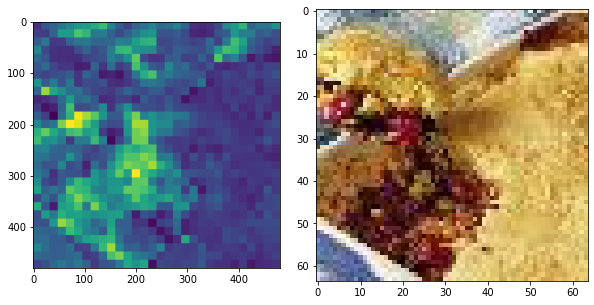

Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class SynapseCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


In [136]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 5))
fig.add_subplot(1, 1, 1)
img = plt.imread('tiny-imagenet-200/test/images/test_1.jpeg')
plt.imshow(img)
fig.add_subplot(1, 3, 1)
attn = plt.imread('attn-head0.png')
plt.imshow(attn)

# Reference

https://docs.microsoft.com/en-us/azure/machine-learning/how-to-train-pytorch